__Purpose:__ Test the performance of already trained decoders to see if they continue to achieve the best performance, and to see if personalization is necessary/possible.  Ideally, this NB should show that the outputs of previous training rounds will maintain their high performance.  I am ambivalent about whether or not we would expect any further improvement over training.

In [1]:
import pandas as pd
import os
import numpy as np
np.random.seed(0)
import random
random.seed(0)
from matplotlib import pyplot as plt

#import seaborn as sns
#from presentation_sns_config import *

from experiment_params import *
from cost_funcs import *
from fl_sim_client import *
from fl_sim_server import *
import time
import pickle

from itertools import permutations

In [2]:
path = r'C:\Users\kdmen\Desktop\Research\Data\CPHS_EMG'
cond0_filename = r'\cond0_dict_list.p'
all_decs_init_filename = r'\all_decs_init.p'
nofl_decs_filename = r'\nofl_decs.p'
id2color = {0:'lightcoral', 1:'maroon', 2:'chocolate', 3:'darkorange', 4:'gold', 5:'olive', 6:'olivedrab', 
            7:'lawngreen', 8:'aquamarine', 9:'deepskyblue', 10:'steelblue', 11:'violet', 12:'darkorchid', 13:'deeppink'}
implemented_client_training_methods = ['GD', 'FullScipyMin', 'MaxIterScipyMin']
num_participants = 14

# For exclusion when plotting later on
bad_nodes = [] #[1,3,13]

# Federated Learning
## 1 Scipy Step, 100 Iterations
> Note that the thicker, lighter lines are the global model accuracies, whereas the thin lines are the local accuracies.

In [3]:
with open(path+cond0_filename, 'rb') as fp:
    cond0_training_and_labels_lst = pickle.load(fp)
    
#with open(path+all_decs_init_filename, 'rb') as fp:
#    init_decoders = pickle.load(fp)    
#cond0_init_decs = [dec[0, :, :] for dec in init_decoders]

D_0 = np.random.rand(2,64)

In [4]:
num_updates = 18

step_indices = list(range(num_updates))

# FedAvg
## FedAvg Intra-Subject Train/Test Split

In [5]:
user_c0_1ScipyStep = [Client(i, copy.deepcopy(D_0), 'MaxiterScipyMin', cond0_training_and_labels_lst[i], 'streaming', starting_update=10) for i in range(14)]
global_model_1scipystep = Server(1, copy.deepcopy(D_0), opt_method='MaxiterScipyMin', global_method='FedAvg', all_clients=user_c0_1ScipyStep)

big_loop_iters = 100
for i in range(big_loop_iters):
    if i%50==0:
        print(f"Round {i} of {big_loop_iters}")
    global_model_1scipystep.execute_FL_loop()


Running the FEDAVG algorithm as the global method!
Round 0 of 100
Round 50 of 100


In [6]:
print(len(global_model_1scipystep.local_error_log))
print(len(global_model_1scipystep.local_error_log[0]))
print(len(global_model_1scipystep.local_error_log[0][0]))

100
14
3


In [7]:
global_model_1scipystep.local_error_log[0][0]

(0, 1, 0.0420666)

In [8]:
for i in range(14):
    print(global_model_1scipystep.local_error_log[0][i])

(0, 1, 0.0420666)
(1, 1, 0)
(2, 1, 0)
(3, 1, 0)
(4, 1, 0.0417062)
(5, 1, 0)
(6, 1, 0.042166)
(7, 1, 0)
(8, 1, 0)
(9, 1, 0)
(10, 1, 0)
(11, 1, 0)
(12, 1, 0.0342842)
(13, 1, 0.0333886)


In [9]:
for i in range(10):
    print(global_model_1scipystep.local_error_log[i][0])

(0, 1, 0.0420666)
(0, 2, 0.0420666)
(0, 3, 0.0420666)
(0, 4, 0.0234027)
(0, 5, 0.0234027)
(0, 6, 0.0234027)
(0, 7, 0.0143823)
(0, 8, 0.0143823)
(0, 9, 0.0143823)
(0, 10, 0.0086467)


In [12]:
print(len(global_model_1scipystep.global_error_log))
print(len(global_model_1scipystep.global_error_log[0]))
print(len(global_model_1scipystep.global_error_log[0][0]))

100
14
3


In [13]:
global_model_1scipystep.global_error_log[0][0]

(0, 1, 0.0672218)

In [14]:
for i in range(10):
    print(global_model_1scipystep.global_error_log[0][i])

(0, 1, 0.0672218)
(1, 1, 0)
(2, 1, 0)
(3, 1, 0)
(4, 1, 0.0649033)
(5, 1, 0)
(6, 1, 0.0651963)
(7, 1, 0)
(8, 1, 0)
(9, 1, 0)


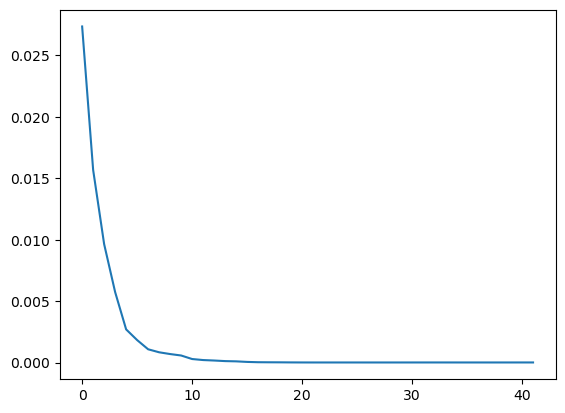

In [17]:
plt.plot([global_model_1scipystep.global_error_log[i][0][2] for i in range(big_loop_iters)], label="FedAvg Global Model Loss (User0)")
plt.plot(user_c0_1ScipyStep[0].Dnorm_log, label="D Norm")
plt.plot(user_c0_1ScipyStep[0].performance_log, label="Performance")
plt.plot(user_c0_1ScipyStep[0].Fnorm_log, label="F Norm")
plt.xlabel("Training Round")
plt.ylabel("Loss")
plt.title("FedAvg Loss: Model and Components")
plt.legend()
plt.show()

In [19]:
id2color = {0:'lightcoral', 1:'maroon', 2:'chocolate', 3:'darkorange', 4:'gold', 5:'olive', 6:'olivedrab', 
        7:'lawngreen', 8:'aquamarine', 9:'deepskyblue', 10:'steelblue', 11:'violet', 12:'darkorchid', 13:'deeppink'}

def moving_average(numbers, window_size):
    i = 0
    moving_averages = []
    while i < len(numbers) - window_size + 1:
        this_window = numbers[i : i + window_size]

        window_average = sum(this_window) / window_size
        moving_averages.append(window_average)
        i += window_size
    return moving_averages

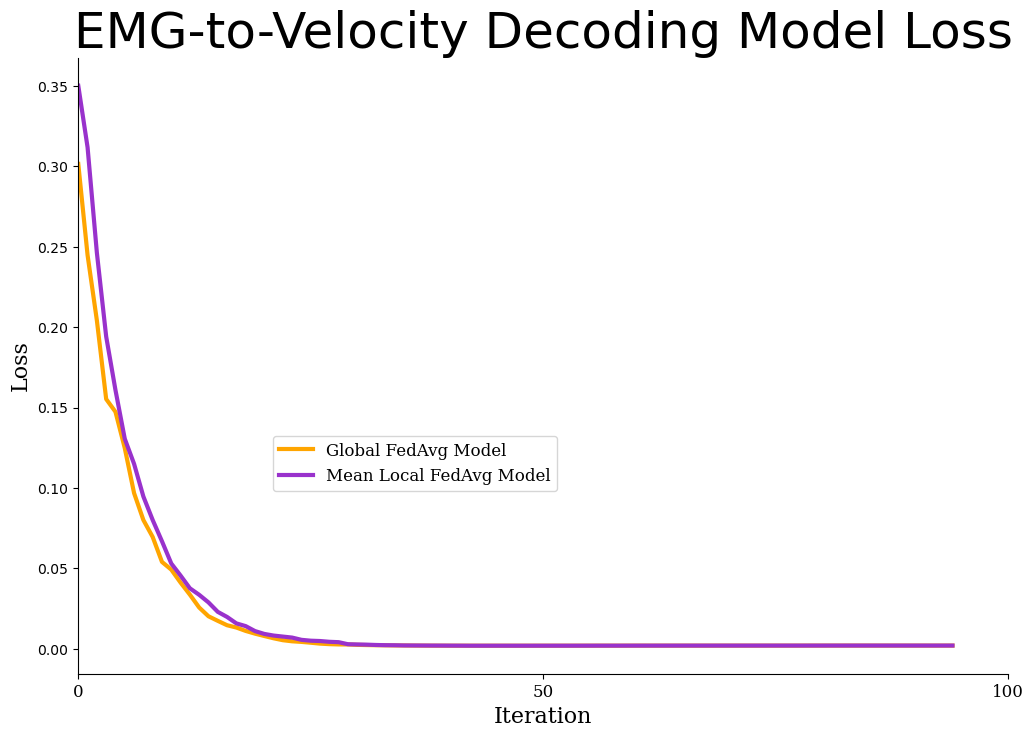

In [20]:
my_title = 'EMG-to-Velocity Decoding Model Loss'
iterable_labels = ['Global FedAvg Model', 'Mean Local FedAvg Model']
# iterable_labels = []

# all_users, all_dfs, all_vecs = central_tendency_plotting([user_nofl_rand_init, user_c0_no_fl_w_cphs_init, user_c0_no_fl_wclient_init], iterable_labels=['Shared Random Init', 'CPHS Init', 'Prev Client Inits'])
all_user_input = [user_c0_1ScipyStep]

plot_mean = True
plot_median = False
exclusion_ID_lst = []
dim_reduc_factor = 1
plot_this_ID_only = -1
global_error = True
local_error = True
different_local_round_thresh_per_client = False
legend_on = True
num_participants = 14
show_update_change = True
custom_title = ""
axes_off_list = []
xlim_max = None
xlim_min = None
ylim_max = None
ylim_min = None
input_linewidth = 3
my_legend_loc = 'best'
iterable_colors = []

plot_testing = True
plot_training = False

num_central_tendencies = 2  # Mean and median... idk, maybe use flags or something...
if dim_reduc_factor!=1:
    raise ValueError("dim_reduc_factor MUST EQUAL 1!")

global_training_df = pd.DataFrame()
local_training_df = pd.DataFrame()
global_testing_df = pd.DataFrame()
local_testing_df = pd.DataFrame()

param_list = [False, False, False, (global_error and plot_training), (local_error and plot_training), False, False, False, False, (global_error and plot_testing), (local_error and plot_testing)]
all_vecs_dict = dict()
all_vecX_dict = dict()
for param_idx, param in enumerate(param_list):
    all_vecs_dict[param_idx] = [[] for _ in range(num_central_tendencies)]
    all_vecX_dict[param_idx] = [[] for _ in range(num_central_tendencies)]
param_label_dict = {0:'Gradient', 1:'Personalized Gradient', 2:'Global Gradient', 3:'Global Training Error', 4:'Local Training Error', 5:'Personalized Error', 6:'Performance', 7:'DNorm', 8:'FNorm', 9:'Global Testing Error', 10:'Local Testing Error'}
tendency_label_dict = {0:'Mean', 1:'Pseudo-Median'}

max_local_iters = 0
label_idx = 0

axes_font = {'family': 'serif', 'color':  'black', 'weight': 'normal', 'size': 16}
title_font = {'family': 'serif', 'color':  'black', 'weight': 'normal', 'size': 22}

# Create a figure and axes object
fig, ax = plt.subplots(figsize=(12, 8))  # Adjust the figsize based on your poster size

# Define colors for plotting
colors = {'GLOBAL': 'orange', 'LOCAL': 'darkorchid', 'PERS': 'blue'}

# Iterate through the data
for user_idx, user_database in enumerate(all_user_input):
    for i in range(len(user_database)):
        # Skip over users that distort the scale
        if user_database[i].ID in exclusion_ID_lst:
            continue
        elif len(user_database[i].local_error_log) < 2:
            # This node never trained so just skip it so it doesn't break the plotting
            continue
        else:
            # This is used for plotting later
            if plot_training:
                if len(user_database[i].local_error_log) > max_local_iters:
                    max_local_iters = len(user_database[i].local_error_log)
                if global_error:
                    df = pd.DataFrame(user_database[i].global_error_log)
                    global_training_df = pd.concat([global_training_df, (df.groupby(df.index // dim_reduc_factor, axis=0).mean()).T])
                if local_error:
                    df = pd.DataFrame(user_database[i].local_error_log)
                    local_training_df = pd.concat([local_training_df, (df.groupby(df.index // dim_reduc_factor, axis=0).mean()).T])
            if plot_testing:
                if len(user_database[i].local_test_error_log) > max_local_iters:
                    max_local_iters = len(user_database[i].local_test_error_log)
                if global_error:
                    df = pd.DataFrame(user_database[i].global_test_error_log)
                    global_testing_df = pd.concat([global_testing_df, (df.groupby(df.index // dim_reduc_factor, axis=0).mean()).T])
                if local_error:
                    df = pd.DataFrame(user_database[i].local_test_error_log)
                    local_testing_df = pd.concat([local_testing_df, (df.groupby(df.index // dim_reduc_factor, axis=0).mean()).T])

    all_dfs_dict = {
        0: 0, 1: 1, 2: 2, 3: global_training_df.reset_index(drop=True), 4: local_training_df.reset_index(drop=True),
        5: 5, 6: 6, 7: 7, 8: 8, 9: global_testing_df.reset_index(drop=True), 10: local_testing_df.reset_index(drop=True)
    }

    for flag_idx, plotting_flag in enumerate(param_list):
        if plotting_flag:
            my_df = all_dfs_dict[flag_idx]
            if plot_mean:
                all_vecs_dict[flag_idx][0] = my_df.mean()
            if plot_median:
                all_vecs_dict[flag_idx][1] = my_df.median()

    label_idx = 0
    for flag_idx, plotting_flag in enumerate(param_list):
        if plotting_flag:
            my_vec = all_vecs_dict[flag_idx]
            for vec_idx, vec_vec in enumerate(my_vec):
                if (plot_mean == True and vec_idx == 0) or (plot_median == True and vec_idx == 1):
                    if iterable_labels != []:
                        my_label = iterable_labels[label_idx]
                        label_idx += 1
                    else:
                        my_label = f"{tendency_label_dict[vec_idx]} {param_label_dict[flag_idx]}"
                    linestyle = 'dashed' if "GLOBAL:" in my_label.upper() else 'solid'
                    #my_color = colors.get([key for key in colors.keys() if key in my_label.upper()][0], 'black')
                    my_color = 'orange' if ('GLOBAL' in my_label.upper()) else 'darkorchid'
                    saved_vec = np.array(vec_vec)
                    x_axis = range(len(vec_vec))
                    ax.plot(x_axis[:-5], vec_vec[:-5], label=my_label, alpha=1, color=my_color,
                            linewidth=input_linewidth, linestyle=linestyle)

# NoFL Scaled Plot
scaled_step_indices = np.array(step_indices) * 50  # Maybe ought to use 100...

# FLSIM PCA 10
#ax.plot(scaled_step_indices[:-2], test_cost_df_FLSim_PCA10.iloc[-1, :-2], linewidth=input_linewidth, label="Averaged Local Models", color='blue')

ax.set_ylabel('Loss', fontdict=axes_font)  # Adjust font size
ax.set_xlabel('Iteration', fontdict=axes_font)  # Adjust font size
#ax1.set_title('Adversarial Model Accuracy Per Data Batch', fontdict=title_font)

ax.set_title(my_title, fontsize=36)  # Adjust font size
#ax.set_ylim(0, 0.016)
ax.set_xlim(0, big_loop_iters)

xtick_positions = np.arange(0, big_loop_iters+1, 50)
xtick_labels = [str(pos) for pos in xtick_positions]  # Convert positions to strings
tick_font = {'family': 'serif', 'color': 'black', 'weight': 'normal', 'size': 12}
plt.xticks(xtick_positions, xtick_labels, fontdict=tick_font)
#ax1.set_xticklabels(xtick_labels, fontdict=tick_font)

#ytick_positions = np.arange(0.002, 0.014, 0.002)
#ytick_labels = [str(pos) for pos in ytick_positions]  # Convert positions to strings
#plt.yticks(ytick_positions, ytick_labels, fontdict=tick_font)

legend_font = {'family': 'serif', 'size': 12}
ax.legend(loc='upper left', prop=legend_font, bbox_to_anchor=(0.2, 0.4))  # Adjust legend font size
ax.spines[['right', 'top']].set_visible(False)

plt.show()


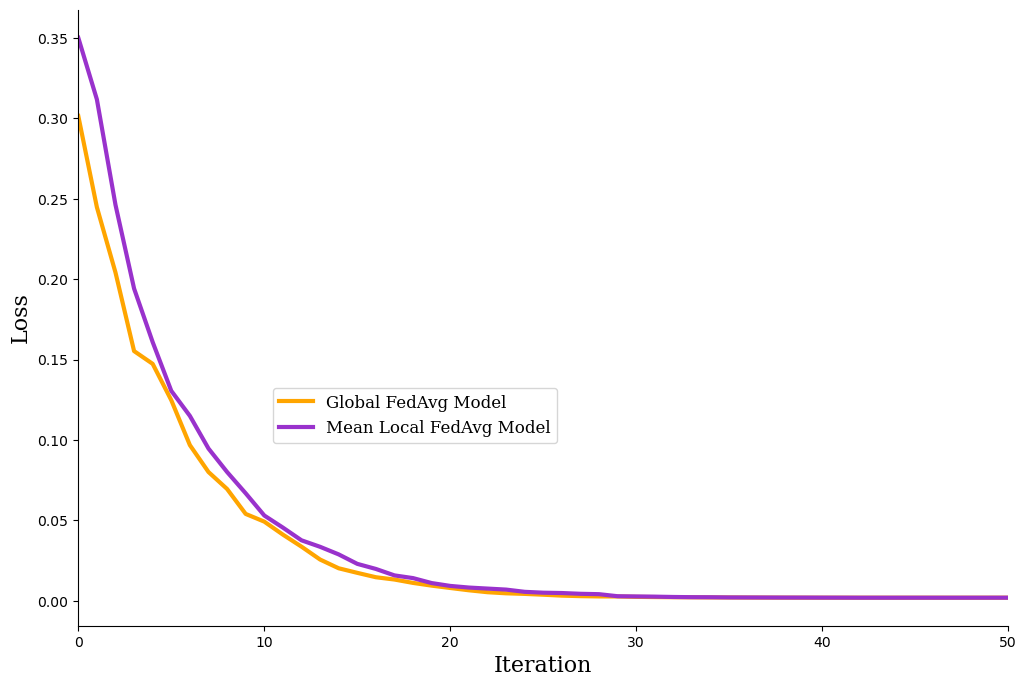

In [21]:
my_title = 'EMG-to-Velocity Decoding Model Testing Error'
iterable_labels = ['Global FedAvg Model', 'Mean Local FedAvg Model']
# iterable_labels = []

# all_users, all_dfs, all_vecs = central_tendency_plotting([user_nofl_rand_init, user_c0_no_fl_w_cphs_init, user_c0_no_fl_wclient_init], iterable_labels=['Shared Random Init', 'CPHS Init', 'Prev Client Inits'])
all_user_input = [user_c0_1ScipyStep]

plot_mean = True
plot_median = False
exclusion_ID_lst = []
dim_reduc_factor = 1
plot_this_ID_only = -1
global_error = True
local_error = True
different_local_round_thresh_per_client = False
legend_on = True
num_participants = 14
show_update_change = True
custom_title = ""
axes_off_list = []
xlim_max = None
xlim_min = None
ylim_max = None
ylim_min = None
input_linewidth = 3
my_legend_loc = 'best'
iterable_colors = []

plot_testing = True
plot_training = False

num_central_tendencies = 2  # Mean and median... idk, maybe use flags or something...
if dim_reduc_factor!=1:
    raise ValueError("dim_reduc_factor MUST EQUAL 1!")

global_training_df = pd.DataFrame()
local_training_df = pd.DataFrame()
global_testing_df = pd.DataFrame()
local_testing_df = pd.DataFrame()

param_list = [False, False, False, (global_error and plot_training), (local_error and plot_training), False, False, False, False, (global_error and plot_testing), (local_error and plot_testing)]
all_vecs_dict = dict()
all_vecX_dict = dict()
for param_idx, param in enumerate(param_list):
    all_vecs_dict[param_idx] = [[] for _ in range(num_central_tendencies)]
    all_vecX_dict[param_idx] = [[] for _ in range(num_central_tendencies)]
param_label_dict = {0:'Gradient', 1:'Personalized Gradient', 2:'Global Gradient', 3:'Global Training Error', 4:'Local Training Error', 5:'Personalized Error', 6:'Performance', 7:'DNorm', 8:'FNorm', 9:'Global Testing Error', 10:'Local Testing Error'}
tendency_label_dict = {0:'Mean', 1:'Pseudo-Median'}

max_local_iters = 0
label_idx = 0

axes_font = {'family': 'serif', 'color':  'black', 'weight': 'normal', 'size': 16}
title_font = {'family': 'serif', 'color':  'black', 'weight': 'normal', 'size': 22}

# Create a figure and axes object
fig, ax = plt.subplots(figsize=(12, 8))  # Adjust the figsize based on your poster size

# Define colors for plotting
colors = {'GLOBAL': 'orange', 'LOCAL': 'darkorchid', 'PERS': 'blue'}

# Iterate through the data
for user_idx, user_database in enumerate(all_user_input):
    for i in range(len(user_database)):
        # Skip over users that distort the scale
        if user_database[i].ID in exclusion_ID_lst:
            continue
        elif len(user_database[i].local_error_log) < 2:
            # This node never trained so just skip it so it doesn't break the plotting
            continue
        else:
            # This is used for plotting later
            if plot_training:
                if len(user_database[i].local_error_log) > max_local_iters:
                    max_local_iters = len(user_database[i].local_error_log)
                if global_error:
                    df = pd.DataFrame(user_database[i].global_error_log)
                    global_training_df = pd.concat([global_training_df, (df.groupby(df.index // dim_reduc_factor, axis=0).mean()).T])
                if local_error:
                    df = pd.DataFrame(user_database[i].local_error_log)
                    local_training_df = pd.concat([local_training_df, (df.groupby(df.index // dim_reduc_factor, axis=0).mean()).T])
            if plot_testing:
                if len(user_database[i].local_test_error_log) > max_local_iters:
                    max_local_iters = len(user_database[i].local_test_error_log)
                if global_error:
                    df = pd.DataFrame(user_database[i].global_test_error_log)
                    global_testing_df = pd.concat([global_testing_df, (df.groupby(df.index // dim_reduc_factor, axis=0).mean()).T])
                if local_error:
                    df = pd.DataFrame(user_database[i].local_test_error_log)
                    local_testing_df = pd.concat([local_testing_df, (df.groupby(df.index // dim_reduc_factor, axis=0).mean()).T])

    all_dfs_dict = {
        0: 0, 1: 1, 2: 2, 3: global_training_df.reset_index(drop=True), 4: local_training_df.reset_index(drop=True),
        5: 5, 6: 6, 7: 7, 8: 8, 9: global_testing_df.reset_index(drop=True), 10: local_testing_df.reset_index(drop=True)
    }

    for flag_idx, plotting_flag in enumerate(param_list):
        if plotting_flag:
            my_df = all_dfs_dict[flag_idx]
            if plot_mean:
                all_vecs_dict[flag_idx][0] = my_df.mean()
            if plot_median:
                all_vecs_dict[flag_idx][1] = my_df.median()

    label_idx = 0
    for flag_idx, plotting_flag in enumerate(param_list):
        if plotting_flag:
            my_vec = all_vecs_dict[flag_idx]
            for vec_idx, vec_vec in enumerate(my_vec):
                if (plot_mean == True and vec_idx == 0) or (plot_median == True and vec_idx == 1):
                    if iterable_labels != []:
                        my_label = iterable_labels[label_idx]
                        label_idx += 1
                    else:
                        my_label = f"{tendency_label_dict[vec_idx]} {param_label_dict[flag_idx]}"
                    linestyle = 'dashed' if "GLOBAL:" in my_label.upper() else 'solid'
                    #my_color = colors.get([key for key in colors.keys() if key in my_label.upper()][0], 'black')
                    my_color = 'orange' if ('GLOBAL' in my_label.upper()) else 'darkorchid'
                    saved_vec = np.array(vec_vec)
                    x_axis = range(len(vec_vec))
                    ax.plot(x_axis[:-5], vec_vec[:-5], label=my_label, alpha=1, color=my_color,
                            linewidth=input_linewidth, linestyle=linestyle)

# NoFL Scaled Plot
scaled_step_indices = np.array(step_indices) * 50  # Maybe ought to use 100...

# FLSIM PCA 10
#ax.plot(scaled_step_indices[:-2], test_cost_df_FLSim_PCA10.iloc[-1, :-2], linewidth=input_linewidth, label="Averaged Local Models", color='blue')

ax.set_ylabel('Loss', fontdict=axes_font)  # Adjust font size
ax.set_xlabel('Iteration', fontdict=axes_font)  # Adjust font size
#ax1.set_title('Adversarial Model Accuracy Per Data Batch', fontdict=title_font)

#ax.set_title(my_title, fontsize=36)  # Adjust font size
#ax.set_ylim(0, 0.016)
ax.set_xlim(0, 50)

legend_font = {'family': 'serif', 'size': 12}
ax.legend(loc='upper left', prop=legend_font, bbox_to_anchor=(0.2, 0.4))  # Adjust legend font size
ax.spines[['right', 'top']].set_visible(False)

plt.show()


## FedAvg with K Fold Cross Validation

In [ ]:
from sklearn.model_selection import KFold
import copy

# Define number of folds
k = 5
kf = KFold(n_splits=k)

# Assuming cond0_training_and_labels_lst is a list of labels for 14 clients
user_ids = list(range(14))
folds = list(kf.split(user_ids))

for fold_idx, (train_ids, test_ids) in enumerate(folds):
    print(f"Fold {fold_idx+1}/{k}")
    
    # Initialize clients for training
    train_clients = [Client(i, copy.deepcopy(D_0), 'FullScipyMin', cond0_training_and_labels_lst[i], 'streaming', starting_update=10) for i in train_ids]
    # Initialize clients for testing
    test_clients = [Client(i, copy.deepcopy(D_0), 'FullScipyMin', cond0_training_and_labels_lst[i], 'streaming', starting_update=10) for i in test_ids]
    testing_datasets_lst = []
    for test_cli in test_clients:
        testing_datasets_lst.append(test_cli.get_testing_dataset())
    for train_cli in train_clients:
        train_cli.set_testset(testing_datasets_lst)

    global_model_LocalNoFL = Server(1, copy.deepcopy(D_0), opt_method='FullScipyMin', global_method='NoFL', all_clients=train_clients)
    
    big_loop_iters = 50
    for i in range(big_loop_iters):
        if i % 10 == 0:
            print(f"Round {i} of {big_loop_iters}")
            # Ought to print the loss too...
        global_model_LocalNoFL.execute_FL_loop()
    
    # Testing phase
    for client in test_clients:
        client.use_kfoldcv = True  # This flag can be used to set different behavior for k-fold CV if needed
        client.set_test_data_and_metrics()  # You may need to implement or modify this method
        # Perform testing and evaluate metrics for the client
        test_results = client.test_model()  # Assuming a method exists to test and return results
        print(f"Test results for client {client.id}: {test_results}")


# Local (NoFL) Run

In [22]:
user_c0_LocalNoFL = [Client(i, copy.deepcopy(D_0), 'FullScipyMin', cond0_training_and_labels_lst[i], 'streaming', starting_update=10) for i in range(14)]
global_model_LocalNoFL = Server(1, copy.deepcopy(D_0), opt_method='FullScipyMin', global_method='NoFL', all_clients=user_c0_LocalNoFL)

big_loop_iters = 100
for i in range(big_loop_iters):
    if i%50==0:
        print(f"Round {i} of {big_loop_iters}")
    global_model_LocalNoFL.execute_FL_loop()


Running the NOFL algorithm as the global method!
Round 0 of 100
Round 50 of 100


In [23]:
print(len(global_model_LocalNoFL.local_error_log))
print(len(global_model_LocalNoFL.local_error_log[0]))
print(len(global_model_LocalNoFL.local_error_log[0][0]))

100
14
3


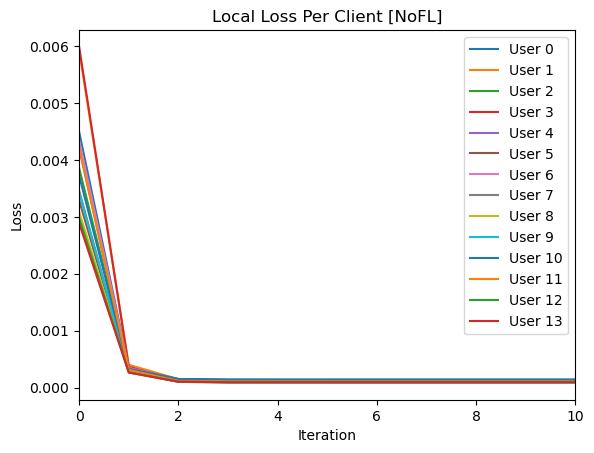

In [27]:
for cli_idx in range(14):
    plt.plot([global_model_LocalNoFL.local_error_log[i][cli_idx][2] for i in range(big_loop_iters)], label=f'User {cli_idx}')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Local Loss Per Client [NoFL]")
plt.legend()
plt.xlim((0, 10))
plt.show()

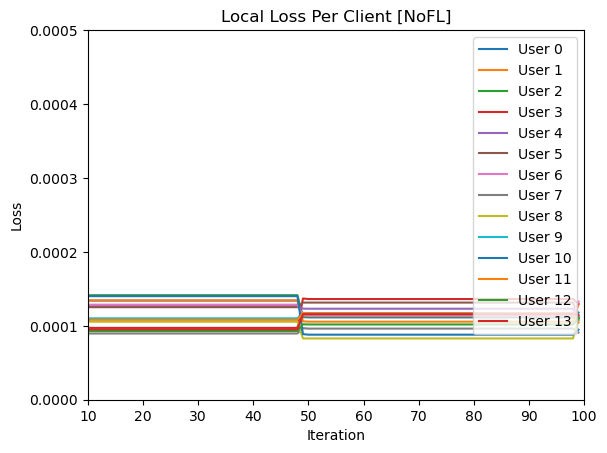

In [30]:
for cli_idx in range(14):
    plt.plot([global_model_LocalNoFL.local_error_log[i][cli_idx][2] for i in range(big_loop_iters)], label=f'User {cli_idx}')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Local Loss Per Client [NoFL]")
plt.legend()
plt.xlim((10, 100))
plt.ylim((0, 0.0005))
plt.show()